<a href="https://mingxia.web.unc.edu/" target="_parent"><img src="https://mingxia.web.unc.edu/wp-content/uploads/sites/12411/2020/12/logo_MagicLab-horizontal-4.png" alt="MAGIC Lab"/></a>

# **JDAC Test and Application**
---

**Loading required libraries**
---

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
import sys, argparse
import enum
import time
import datetime
import random
import json
import multiprocessing
import os.path as osp
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()
import pylab as pl
import logging
import shutil
import tempfile
import gzip
from typing import Optional, Sequence, Tuple, Union
from urllib.request import urlretrieve
from PIL import Image

from pathlib import Path
from scipy import stats
from IPython import display
from tqdm import trange, tqdm

import copy
import pprint
import torchio as tio
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import L1Loss
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
import tensorboardX

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, roc_auc_score, matthews_corrcoef
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.manifold import TSNE
from sklearn import svm

import monai
import monai.transforms as mt
from monai.transforms import Compose
from monai.data import CacheDataset, DataLoader, Dataset, ImageDataset
from monai.networks.nets import VarAutoEncoder,ViTAutoEnc, AutoEncoder
from monai.networks.layers.convutils import calculate_out_shape, same_padding
from monai.networks.layers.factories import Act, Norm
from monai.networks.utils import one_hot
from monai.utils import set_determinism, first
from monai.utils.enums import MetricReduction
from monai.metrics import compute_hausdorff_distance, HausdorffDistanceMetric
from monai.losses import ContrastiveLoss, DiceLoss, DiceCELoss
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet,BasicUNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract

torch.manual_seed(0)
set_determinism(seed=0)

pin_memory = False
device = 'cpu'

C:\Users\zhlt1\.conda\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Global Setting**
---

In [2]:
logdir_path = './PretrainedModels/'
if os.path.exists(logdir_path)==False:
    os.mkdir(logdir_path)

**File scanner**
---

In [3]:
class ScanFile(object):
    def __init__(self, directory, prefix=None, postfix=None):
        self.directory = directory
        self.prefix = prefix
        self.postfix = postfix

    def scan_files(self):
        files_list = []

        for dirpath, dirnames, filenames in os.walk(self.directory):
            ''''' 
            dirpath is a string, the path to the directory.   
            dirnames is a list of the names of the subdirectories in dirpath (excluding '.' and '..'). 
            filenames is a list of the names of the non-directory files in dirpath. 
            '''
            for special_file in filenames:
                if self.postfix:
                    if special_file.endswith(self.postfix):
                        files_list.append(os.path.join(dirpath, special_file))
                elif self.prefix:
                    if special_file.startswith(self.prefix):
                        files_list.append(os.path.join(dirpath, special_file))
                else:
                    files_list.append(os.path.join(dirpath, special_file))

        return files_list

    def scan_subdir(self):
        subdir_list = []
        for dirpath, dirnames, files in os.walk(self.directory):
            subdir_list.append(dirpath)
        return subdir_list


**Loading Pretrained Models**
---

In [4]:
from models import AntiART_UNet,Denoiser_CondUNet
RESUME_Denoiser = True
RESUME_AntiArt = True
OUT_DIR = logdir_path
RESUME_CHP_DIR = logdir_path

epoch_start = 0
if RESUME_Denoiser:
    Denoiser = Denoiser_CondUNet(spatial_dims=3, in_channels=1, out_channels=1, features=(16, 32, 64, 128, 128, 16), norm='batch',upsample='nontrainable')
    model_path = logdir_path+'Pretrained_Denoiser_l1loss_epoch15.pth'
    Denoiser = Denoiser.to(device)
    if device == 'cpu':
        states = torch.load(model_path, map_location=lambda storage, loc: storage)
        Denoiser.load_state_dict(states['weights'])
    else:
        states = torch.load(model_path)
        Denoiser.load_state_dict(states['weights'])
    Denoiser.eval()
    print("loaded Denoiser:"+model_path)
if RESUME_AntiArt:
    AntiArt = AntiART_UNet(spatial_dims=3, in_channels=1, out_channels=1, features=(16, 32, 64, 128, 128, 16), norm='batch',upsample='nontrainable')#
    model_path = logdir_path+'Pretrained_AntiArtNet_l1loss_epoch150.pth'
    AntiArt  = AntiArt.to(device)
    if device == 'cpu':
        states = torch.load(model_path, map_location=lambda storage, loc: storage)
        AntiArt.load_state_dict(states['weights'])
    else:
        states = torch.load(model_path)
        AntiArt.load_state_dict(states['weights'])
    AntiArt.eval()
    print("loaded AntiArt:"+model_path)

fSSIM   = monai.metrics.regression.SSIMMetric(spatial_dims=3, data_range=1.0)
fMSSSIM = monai.metrics.MultiScaleSSIMMetric(spatial_dims=3, data_range=1.0, kernel_size=7)
fPSNR   = monai.metrics.PSNRMetric(max_val=1.0, reduction=MetricReduction.MEAN, get_not_nans=False)
fRMSE   = monai.metrics.RMSEMetric(reduction=MetricReduction.MEAN, get_not_nans=False)


BasicUNet features: (16, 32, 64, 128, 128, 16).
loaded Denoiser:./PretrainedModels/Pretrained_Denoiser_l1loss_epoch15.pth
BasicUNet features: (16, 32, 64, 128, 128, 16).
loaded AntiArt:./PretrainedModels/Pretrained_AntiArtNet_l1loss_epoch150.pth


**JDAC Framework**
---

In [10]:
def torch_gradmap(img):
    dh = img[:,:,:,:,1:] - img[:,:,:,:,:-1]
    dw = img[:,:,:,1:,:] - img[:,:,:,:-1,:]
    dz = img[:,:,1:,:,:] - img[:,:,:-1,:,:]
    gra_map = (dh[:,:,1:, 1:, :] + dw[:,:,1:,:,1:] + dz[:,:,:,1:,1:])/3.
    gra_map=torch.nn.functional.pad(gra_map, (1,0,1,0,1,0), "constant", 0) 
    return gra_map

def torch_std_estimate(img):
    dh = img[:,:,:,:,1:] - img[:,:,:,:,:-1]
    dw = img[:,:,:,1:,:] - img[:,:,:,:-1,:]
    dz = img[:,:,1:,:,:] - img[:,:,:-1,:,:]
    gra_map = (dh[:,:,1:, 1:, :] + dw[:,:,1:,:,1:] + dz[:,:,:,1:,1:])/3.
    gra_std = torch.std(gra_map, dim=(-1,-2,-3), keepdim=True)   
    return gra_std

def anti_artifacts3d(antiartNet,perturbed_samples, step_lr=1.0):
    '''
    input shape: (n,1,h,w,d)
    output shape: (n,1,h,w,d)
    '''    
    mt_scale = mt.ScaleIntensity(minv=0., maxv=1.0)
    perturbed_samples = mt_scale(perturbed_samples)
    perturbed_samples = perturbed_samples*255
    scores,scores_down = antiartNet(perturbed_samples)
    scores = scores/255.0
    perturbed_samples = perturbed_samples/255.0
    res = (perturbed_samples-scores)
    res = (res - torch.mean(res)).clip(-0.04,0.04)
    denoised = perturbed_samples - step_lr * res
    return (denoised.clip(0,1))

def denoiser3d(denoiserNet, v_var, sigma=None):
    mt_scale = mt.ScaleIntensity(minv=0., maxv=1.0)
    v_var = mt_scale(v_var)
    if sigma is None:
        sigma = torch.abs((torch_std_estimate(v_var)-0.028))
    predict,_,_ = denoiserNet(v_var, sigma)
    used_sigmas2 = sigma ** 2
    predict_noise = (predict*used_sigmas2)
    denoised = v_var - (predict_noise)
    return (denoised.clip(0,1)) 

def DenoiseAndAntiArt(Denoiser, AntiArt, noise_patch, learning_rate=0.2, max_iter=4, threshold_std = 0.028, earlystop=False, show=False):
    v = noise_patch.clone()
    x = v.clone()
    u = torch.zeros_like(v)

    #x_old = x.clone()
    for idx in range(max_iter):
        x_old = x.clone()
        v_old = v.clone()
        u_old = u.clone()
        x = x_old*(1-learning_rate) + v*(learning_rate)
        xu = (x - u)#.clip(0,1)
        sigma = est_sigma = torch_std_estimate(xu).item()
        v = denoiser3d(Denoiser, xu, torch.tensor(sigma))
        v_sub_u = (v+u).clip(0,1)
        est_sigma = torch_std_estimate(v_sub_u).item()
        x = anti_artifacts3d(AntiArt,v_sub_u)
        u = (v_sub_u-x)
        
        est_sigma = torch_std_estimate(x).item()
        if earlystop and est_sigma<threshold_std:
            print('earlystop')
            break
    est_sigma = torch_std_estimate(x).item()
    return x,est_sigma


**Test on MRART**
---

***Preparing files***
---

In [11]:
MR_ART_dir_out = './SampleData/MRART/'
scan1 = ScanFile(MR_ART_dir_out, postfix='standard_T1w_brain_176_216_176.nii.gz')
scan2 = ScanFile(MR_ART_dir_out, postfix='headmotion1_T1w_brain_dof6_176_216_176.nii.gz')
scan3 = ScanFile(MR_ART_dir_out, postfix='headmotion2_T1w_brain_dof6_176_216_176.nii.gz')

mri_list1  = sorted(scan1.scan_files())
mri_list2  = sorted(scan2.scan_files())
mri_list3  = sorted(scan3.scan_files())
print('standard_MRI_Number:'+str(len(mri_list1))+'  headmotion1_Number:'+str(len(mri_list2))+'  headmotion2_Number:'+str(len(mri_list3)))

filepath = mri_list1[0]
print('filepath:'+filepath)
MRIf_first = nib.load(filepath)
#image_data = MRIf_first.get_fdata()
#image_head = MRIf_first.header

vol_size  = (MRIf_first.header['dim'][1:4])
pix_space = (MRIf_first.header['pixdim'][1:4])
print(vol_size)

MRI_dict_list = []
for item1,item2,item3 in zip(mri_list1,mri_list2,mri_list3):
    MRI_dict_list.append({'mristd':item1,'headmotion':item2})
    MRI_dict_list.append({'mristd':item1,'headmotion':item3})

MRI_list = MRI_dict_list

test_number  = int(len(MRI_list)*0.2)
train_number = int((len(MRI_list)-test_number)*1.0)
print('train_number:'+str(train_number))
print('test_number:'+str(test_number))

train_files = MRI_list[0:train_number]
test_files  = MRI_list[-test_number:]
print(train_files[-2])
print(train_files[-1])
random.shuffle(train_files)


standard_MRI_Number:6  headmotion1_Number:6  headmotion2_Number:6
filepath:./SampleData/MRART/sub-000103_acq-standard_T1w_brain_176_216_176.nii.gz
[176 216 176]
train_number:10
test_number:2
{'mristd': './SampleData/MRART/sub-000175_acq-standard_T1w_brain_176_216_176.nii.gz', 'headmotion': './SampleData/MRART/sub-000175_acq-headmotion1_T1w_brain_dof6_176_216_176.nii.gz'}
{'mristd': './SampleData/MRART/sub-000175_acq-standard_T1w_brain_176_216_176.nii.gz', 'headmotion': './SampleData/MRART/sub-000175_acq-headmotion2_T1w_brain_dof6_176_216_176.nii.gz'}


***Minimal Preprocessing***
---

In [12]:
test_transforms = Compose(
    [
        mt.LoadImaged(keys=['mristd', 'headmotion'], ensure_channel_first=True, image_only=True),
        mt.ScaleIntensityRangePercentilesd(keys=['mristd', 'headmotion'],lower=0, upper=98, b_min=0., b_max=1.0, clip=True),
        mt.CropForegroundd(keys=['mristd', 'headmotion'], source_key="mristd", mode='empty'),
        mt.DivisiblePadd(keys=['mristd', 'headmotion'],k=16),
    ]
)
test_ds = Dataset(data=test_files, transform=test_transforms)
loader_test = DataLoader(test_ds, batch_size=1)

check_data = first(loader_test)
print(f"check_data shape: {check_data['mristd'].shape}")
print(f"check_data shape: {check_data['headmotion'].shape}")

check_data shape: torch.Size([1, 1, 144, 176, 160])
check_data shape: torch.Size([1, 1, 144, 176, 160])


***Data Loader Test***
---

check_data shape: torch.Size([1, 1, 144, 176, 160])
check_data shape: torch.Size([1, 1, 144, 176, 160])
image shape: torch.Size([144, 176, 160])


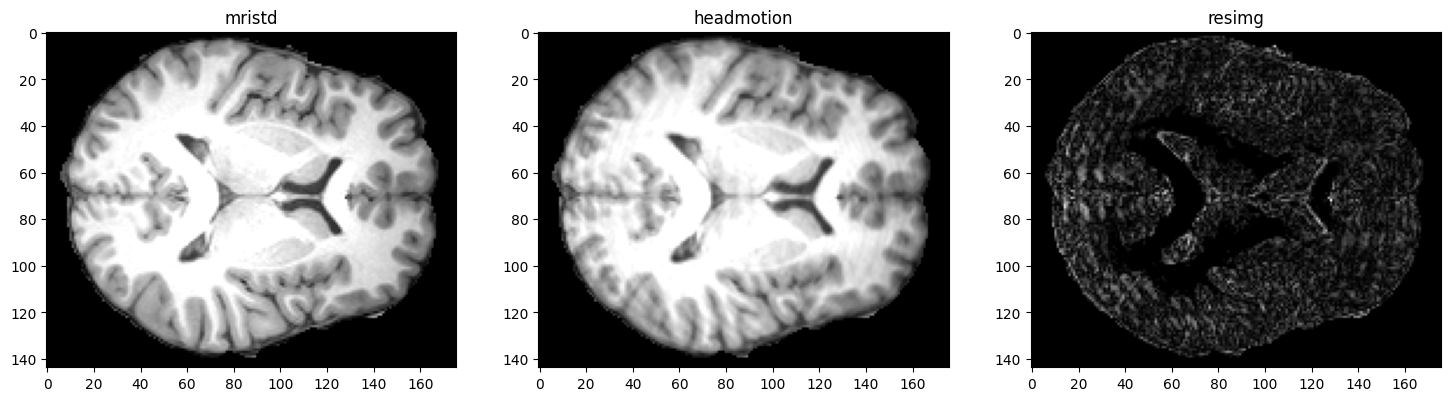

In [13]:
slceZ = 84
#print(check_data)
print(f"check_data shape: {check_data['mristd'].shape}")
print(f"check_data shape: {check_data['headmotion'].shape}")
image0 = check_data['mristd'][0][0]
image1 = check_data['headmotion'][0][0]
print(f"image shape: {image0.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (18, 6))
plt.subplot(1, 3, 1)
plt.title("mristd")
plt.imshow(image0[:, :, slceZ], cmap="gray")
plt.grid(visible=False)
plt.subplot(1, 3, 2)
plt.title("headmotion")
plt.imshow(image1[:, :, slceZ], cmap="gray")
plt.grid(visible=False)
plt.subplot(1, 3, 3)
plt.title("resimg")
plt.imshow(abs(image1-image0)[:, :, slceZ], cmap="gray")
plt.grid(visible=False)
plt.show()

***Test on MRIs in the MR-ART***
---

In [14]:
sigmalist = [0.125, 0.075, 0.025]
for sigma in sigmalist:
    psnr   = []
    rmse   = []
    ssim   = []
    msssim = []
    psnr1   = []
    rmse1   = []
    ssim1   = []
    msssim1 = []
    noise_sigma = torch.tensor(sigma)
    noise_sigma = noise_sigma.to(device).view(1,1,1,1,1)
    with tqdm(total=len(loader_test), desc='Test', miniters=1) as t:
        for i, (batch) in enumerate(loader_test):
            image_target = batch['mristd'].to(device).float()
            samples      = batch['headmotion'].to(device).float()
            mask = samples>0
            noise = torch.randn_like(samples)*noise_sigma.to(device) 
            perturbed_samples = (samples + noise).clip(0,1)#* mask

            with torch.no_grad():
                denoised,_ = DenoiseAndAntiArt(Denoiser, AntiArt, perturbed_samples)
                
          
            batch_psnr   = fPSNR(    image_target, denoised)
            batch_rmse   = fRMSE(    image_target, denoised)
            batch_ssim   = fSSIM(  image_target, denoised)
            batch_msssim = fMSSSIM(image_target, denoised)
            psnr.append(torch.mean(batch_psnr).item())
            rmse.append(torch.mean(batch_rmse).item())
            ssim.append(torch.mean(batch_ssim).item())
            msssim.append(torch.mean(batch_msssim).item())

            denoised_grad     = torch_gradmap(denoised)
            image_target_grad = torch_gradmap(image_target)
            batch_psnr   = fPSNR(    denoised_grad,image_target_grad)
            batch_rmse   = fRMSE(    denoised_grad,image_target_grad)
            batch_ssim   = fSSIM(  denoised_grad,image_target_grad)
            batch_msssim = fMSSSIM(denoised_grad,image_target_grad)
            psnr1.append(torch.mean(batch_psnr).item())
            rmse1.append(torch.mean(batch_rmse).item())
            ssim1.append(torch.mean(batch_ssim).item())
            msssim1.append(torch.mean(batch_msssim).item())

            t.set_postfix_str("PSNR: %.4f, RMSE: %.4f, SSIM: %.4f, MSSSIM: %.4f" % (psnr[-1], rmse[-1], ssim[-1], msssim[-1]))
            t.update()

            #break
            
    noise_std   = noise_sigma.squeeze().item()
    psnr_mean   = np.mean(psnr)
    psnr_std    = np.std(psnr)
    rmse_mean   = np.mean(rmse)
    rmse_std    = np.std(rmse)
    ssim_mean   = np.mean(ssim)
    ssim_std    = np.std(ssim)
    msssim_mean = np.mean(msssim)
    msssim_std  = np.std(msssim)

    psnr_mean1   = np.mean(psnr1)
    psnr_std1    = np.std(psnr1)
    rmse_mean1   = np.mean(rmse1)
    rmse_std1    = np.std(rmse1)
    ssim_mean1   = np.mean(ssim1)
    ssim_std1    = np.std(ssim1)
    msssim_mean1 = np.mean(msssim1)
    msssim_std1  = np.std(msssim1)

    print("Noise Std: %.3f, PSNR: %.2f\xB1%.2f, RMSE: %.4f\xB1%.4f, SSIM: %.4f\xB1%.4f, MSSSIM: %.4f\xB1%.4f" % (noise_std, psnr_mean, psnr_std, rmse_mean,rmse_std, ssim_mean,ssim_std, msssim_mean,msssim_std))
    print("Gradient map: \nNoise Std: %.3f, PSNR: %.2f\xB1%.2f, RMSE: %.4f\xB1%.4f, SSIM: %.4f\xB1%.4f, MSSSIM: %.4f\xB1%.4f" % (noise_std, psnr_mean1, psnr_std1, rmse_mean1,rmse_std1, ssim_mean1,ssim_std1, msssim_mean1,msssim_std1))


Test: 100%|██████████| 2/2 [01:02<00:00, 31.22s/it, PSNR: 17.9059, RMSE: 0.1273, SSIM: 0.3429, MSSSIM: 0.8371]


Noise Std: 0.125, PSNR: 17.97±0.06, RMSE: 0.1264±0.0009, SSIM: 0.3462±0.0033, MSSSIM: 0.8396±0.0026
Gradient map: 
Noise Std: 0.125, PSNR: 29.80±0.02, RMSE: 0.0324±0.0001, SSIM: 0.6578±0.0025, MSSSIM: 0.9279±0.0018


Test: 100%|██████████| 2/2 [01:02<00:00, 31.07s/it, PSNR: 18.6635, RMSE: 0.1166, SSIM: 0.3465, MSSSIM: 0.8603]


Noise Std: 0.075, PSNR: 18.74±0.08, RMSE: 0.1156±0.0011, SSIM: 0.3495±0.0030, MSSSIM: 0.8619±0.0016
Gradient map: 
Noise Std: 0.075, PSNR: 29.67±0.02, RMSE: 0.0328±0.0001, SSIM: 0.6426±0.0022, MSSSIM: 0.9316±0.0014


Test: 100%|██████████| 2/2 [01:00<00:00, 30.12s/it, PSNR: 19.2994, RMSE: 0.1084, SSIM: 0.3559, MSSSIM: 0.8691]

Noise Std: 0.025, PSNR: 19.34±0.04, RMSE: 0.1079±0.0005, SSIM: 0.3587±0.0028, MSSSIM: 0.8711±0.0020
Gradient map: 
Noise Std: 0.025, PSNR: 29.70±0.01, RMSE: 0.0327±0.0000, SSIM: 0.6438±0.0012, MSSSIM: 0.9348±0.0015


**Applying on NBOLD**
---

***Preparing files***
---

In [15]:
NBOLD_mri_dir = './SampleData/NBOLD/'
scan1 = ScanFile(NBOLD_mri_dir, postfix='nii.gz')

mri_list  = sorted(scan1.scan_files())
print('NBOLD_MRI_Number:'+str(len(mri_list)))

filepath = mri_list[0]
print('filepath:'+filepath)
MRIf_first = nib.load(filepath)
#image_data = MRIf_first.get_fdata()
#image_head = MRIf_first.header

vol_size  = (MRIf_first.header['dim'][1:4])
pix_space = (MRIf_first.header['pixdim'][1:4])
#print(vol_size)
#print(pix_space)

MRI_dict_list1 = []
for item in mri_list:
    MRI_dict_list1.append({'mristd':item})

MRI_list = MRI_dict_list1

test_number  =  int(len(MRI_list))
print('test_number:'+str(test_number))
test_files  = MRI_list

NBOLD_MRI_Number:3
filepath:./SampleData/NBOLD/Sample1.nii.gz
test_number:3


***Minimal Preprocessing***
---

In [18]:
def threshold_at_one(x):
    # threshold at 1
    return x > 0.01
apply_trans = Compose(
    [
        mt.CropForeground(select_fn=threshold_at_one, margin=0),
        mt.ScaleIntensityRangePercentiles(0, 98, 0.0, 1.0, True),
        mt.DivisiblePad(k=16),
    ]
)

monai.transforms.croppad.array CropForeground.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.3.


***Applying***
---

In [22]:
import time
import nibabel as nib
idx = 0

mri_path_list = test_files
filepath = mri_path_list[idx]['mristd']
print(filepath)
   
img = nib.load(filepath)
image_data = img.get_fdata()
#print(img.header)
#print(img.affine)
#print(image_data.shape)

img_original = torch.tensor(image_data).unsqueeze(0)
img_original = apply_trans(img_original)
img_original = img_original.unsqueeze(0).float()
img_preproc  = nib.Nifti1Image(img_original[0][0],img.affine, img.header)
nib.save(img_preproc, filepath.replace('.nii.gz', '_preprocimg.nii.gz')) 

mask  = img_original>0

print(' start！')
time_start = time.time()
with torch.no_grad():
    return_tuple = DenoiseAndAntiArt(Denoiser, AntiArt, img_original, max_iter=4, earlystop=True)
    denoised = return_tuple[0]
        

denoised_img = denoised*mask
denoised_gradmap = torch_gradmap(denoised_img)
denoised_std = torch.std(denoised_img)
denoised_grad_std = torch_std_estimate(denoised_img).item()

print(f"denoised Std: %.3f, denoisedGrad Std: %.3f" % (denoised_std,denoised_grad_std))

noised         = nib.Nifti1Image(denoised_img[0][0],    img.affine, img.header)
noised_gradmap = nib.Nifti1Image(denoised_gradmap[0][0],img.affine, img.header)

nib.save(noised,        filepath.replace('.nii.gz', '_denoisedimg.nii.gz')) 
nib.save(noised_gradmap,filepath.replace('.nii.gz', '_denoisedimggrad.nii.gz')) 
time_end = time.time()

print(' time consuming : '+str(time_end-time_start))    
print(' finished！')

./SampleData/NBOLD/Sample1.nii.gz
 start！
earlystop
denoised Std: 0.333, denoisedGrad Std: 0.029
 time consuming : 15.360471487045288
 finished！
